KEYWORD SPOTTING USING MFCC IN TENSORFLOW

To run this notebook, make sure to have Python 3.10.0 installed.

To install Python 3.10.0, 
1) Go to the link below:
  https://www.python.org/downloads/release/python-3100/
2) Click on the suitable installer (If using Windows, download Windows installer (64-bit))
3) As you run the installer, check on the box "Add Python 3.10 to PATH" and then install


!pip install tensorflow==2.13.0 librosa scikit-learn numpy pyaudio matplotlib  IPython seaborn pathlib

Importing the necessary libraries

In [1]:
import os

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pickle
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import pyaudio

import time

import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, LSTM,Reshape,AveragePooling2D, GlobalAveragePooling2D
from IPython import display

LOADING FILES AND MAKING MFCCS:
We go through each directory in the path of the folder given, and assign each audio mfcc with the corresponding folder names in the 'labels' variable

In [3]:

def load_wav_files(folder_path):
    data = []
    labels = []
    wave=[]
    label_list=[]
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                if filename.endswith(".wav"):
                    # Load audio file
                    audio_data, _ = librosa.load(file_path, sr=16000) # Sample rate is considered as 16kHz
                    mfccs = librosa.feature.mfcc(y=audio_data, sr=16000, n_mfcc=13)# No. of mfccs for each audio is taken as 13 with sampling rate as 16kHz
                    wave.append(audio_data)
                    data.append(mfccs)
                    labels.append(label)
                    label_list.append(label) if label not in label_list else None
    return wave,data,labels,label_list


# Specify the root folder containing subfolders with audio files
root_folder = r"C:\Coding\Deep Learning\Audio Processing\Classifiers\mini_speech_commands"# Input the PATH containing the audio files with their respective labels from the user
# root_folder = pathlib.Path(root_folder)
wave,mfcc, labels,label_list = load_wav_files(root_folder)

The following labels are detected

In [4]:
print(label_list) 

['go', 'noise', 'off', 'on', 'stop', 'unknown']


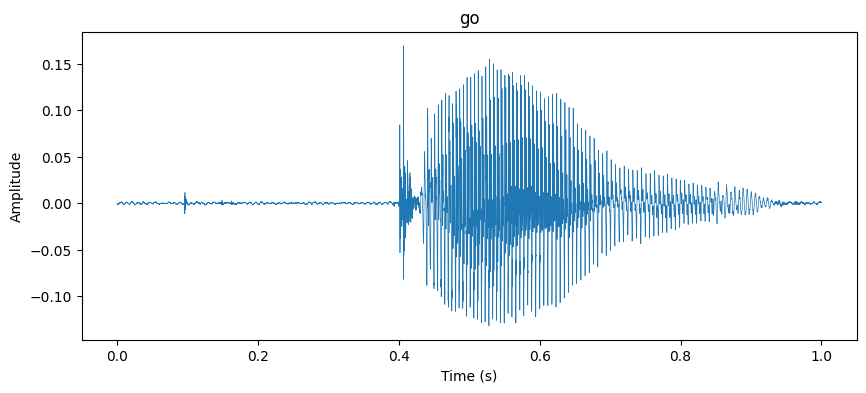

Audio playback


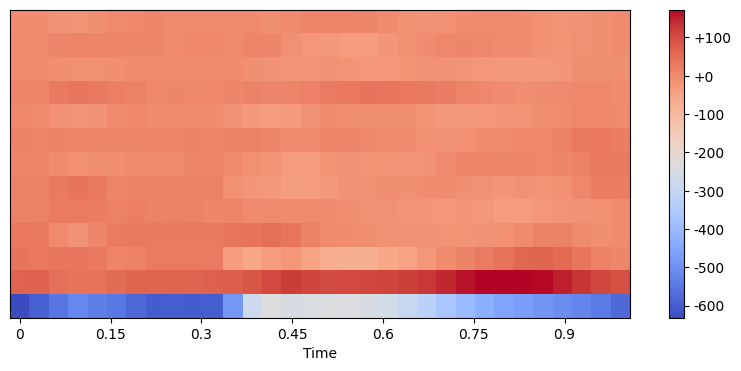

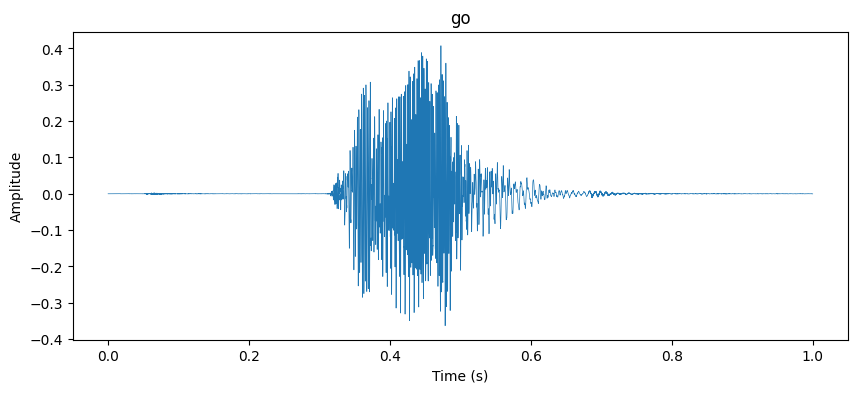

Audio playback


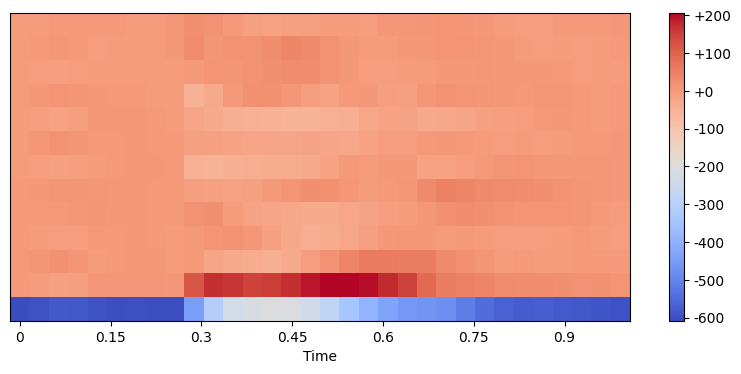

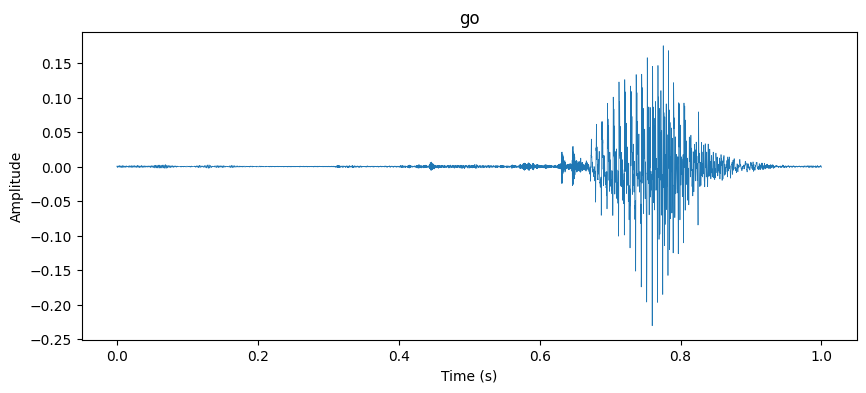

Audio playback


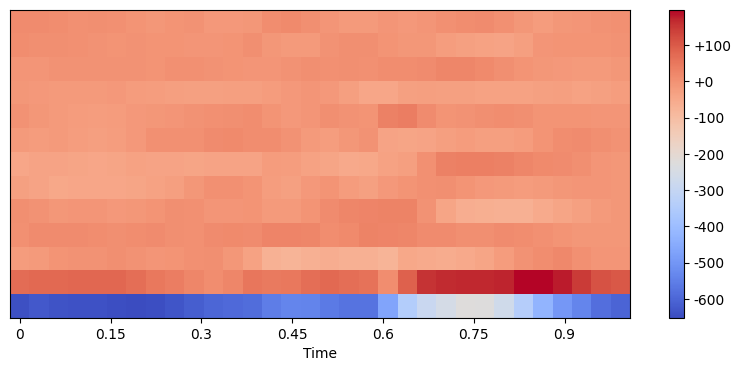

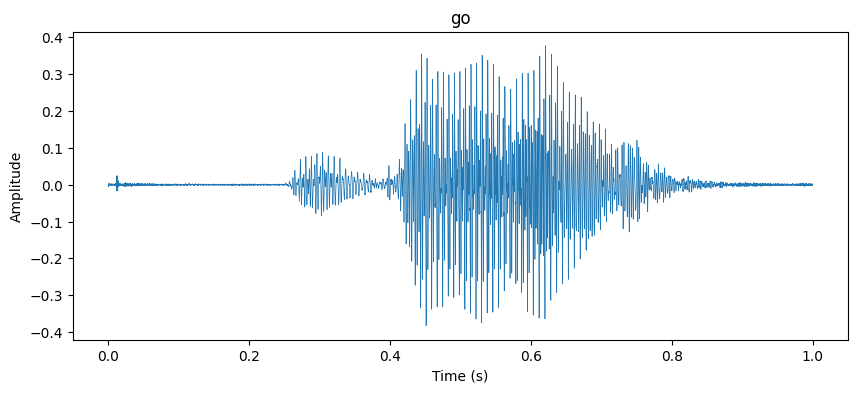

Audio playback


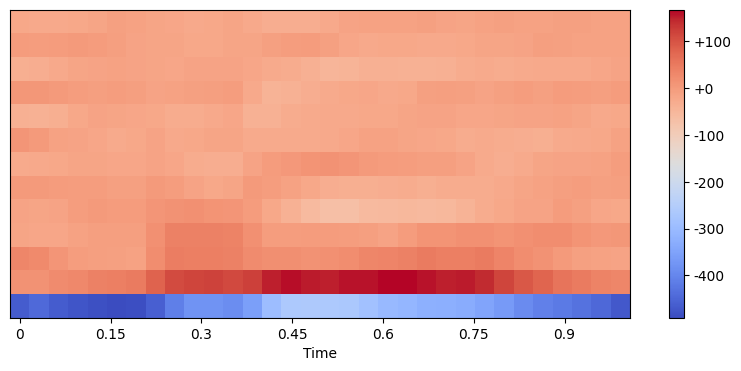

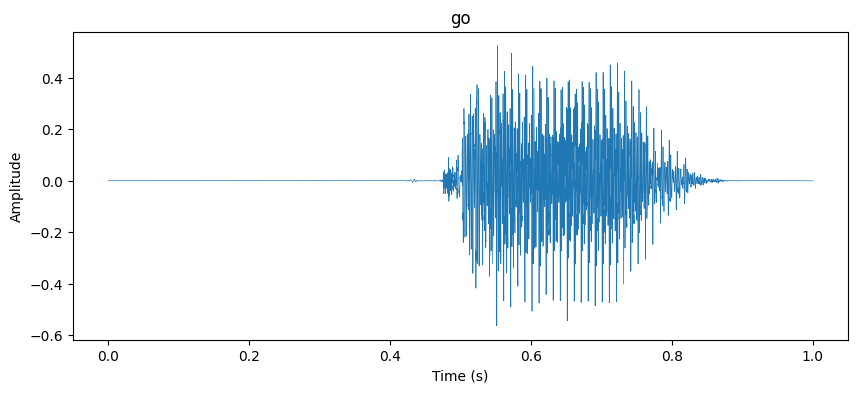

Audio playback


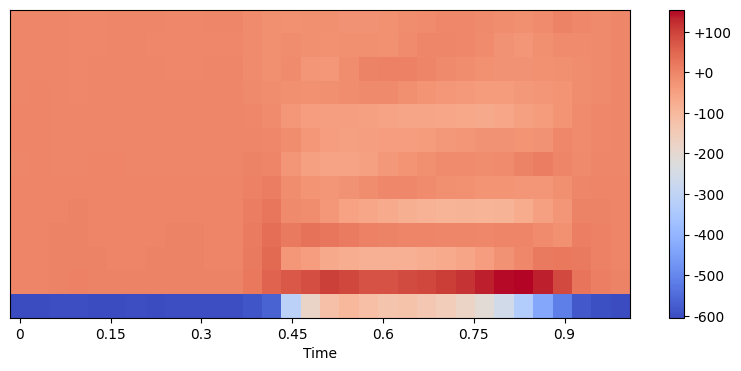

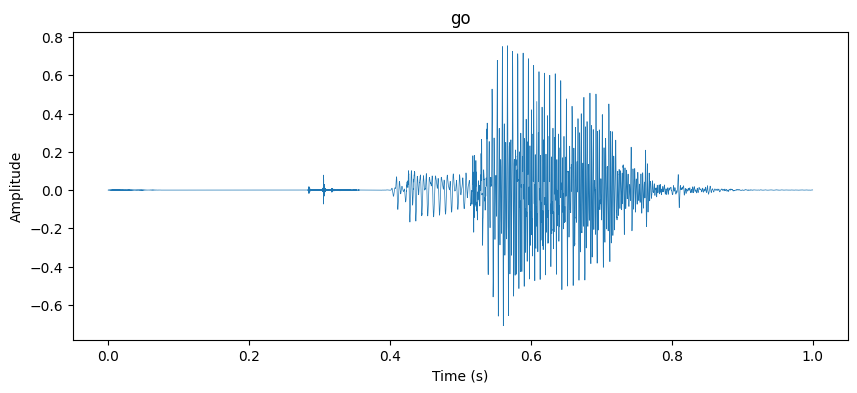

Audio playback


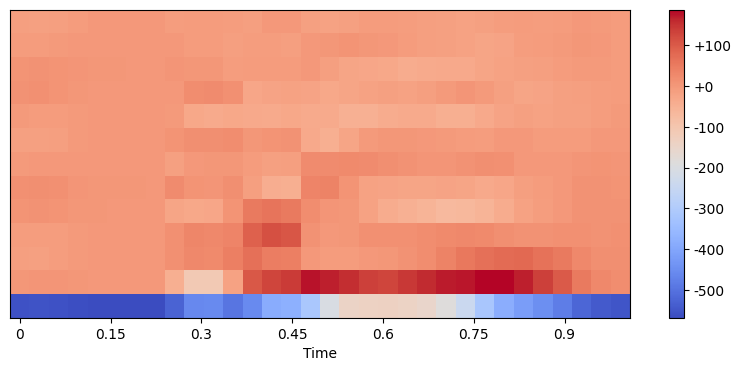

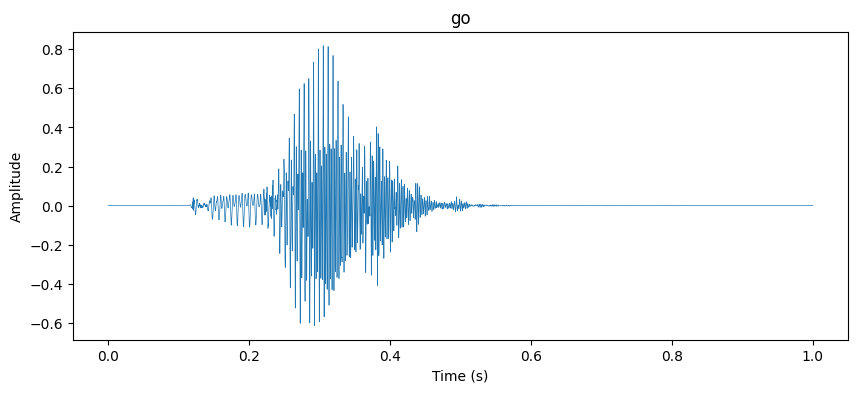

Audio playback


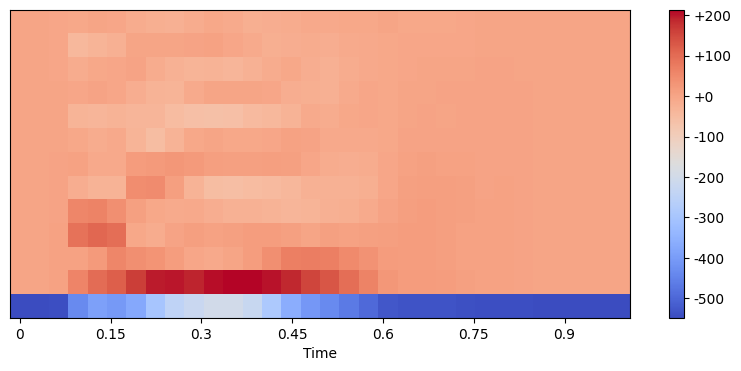

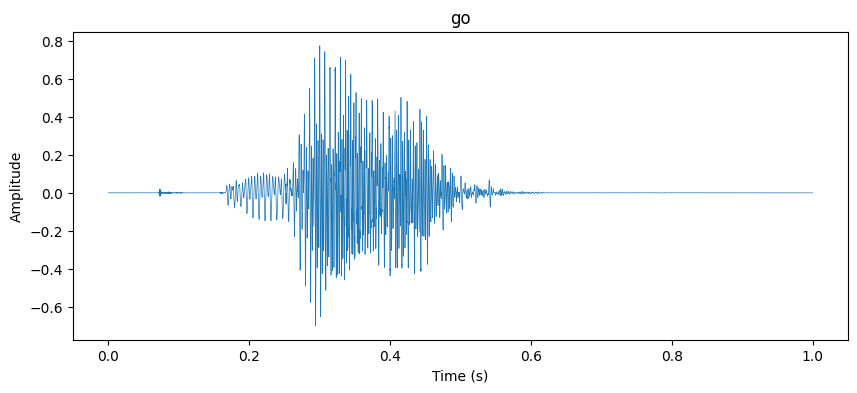

Audio playback


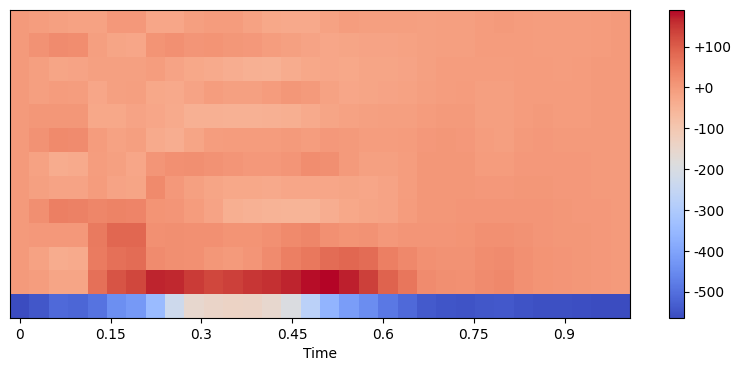

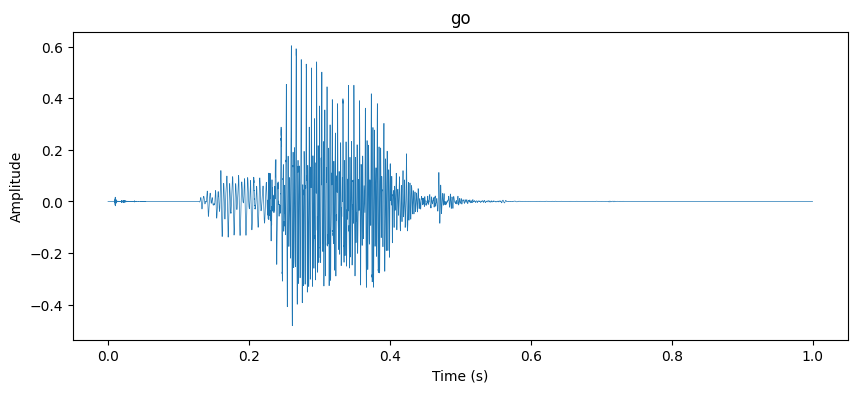

Audio playback


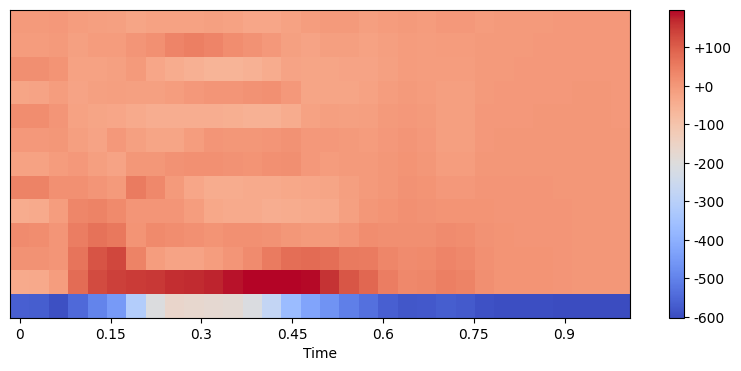

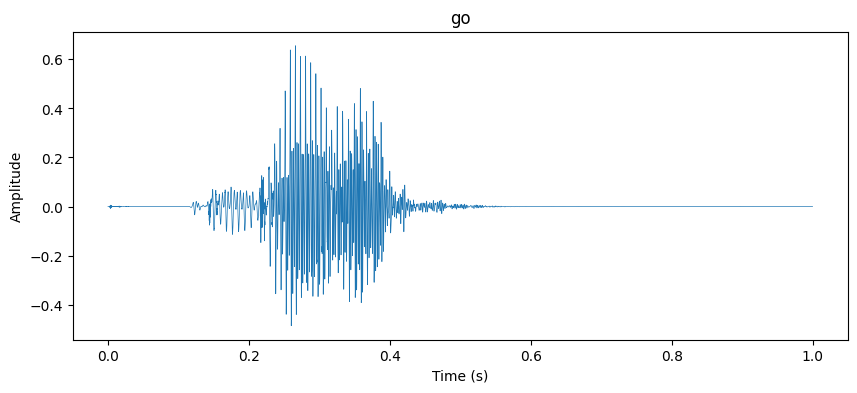

Audio playback


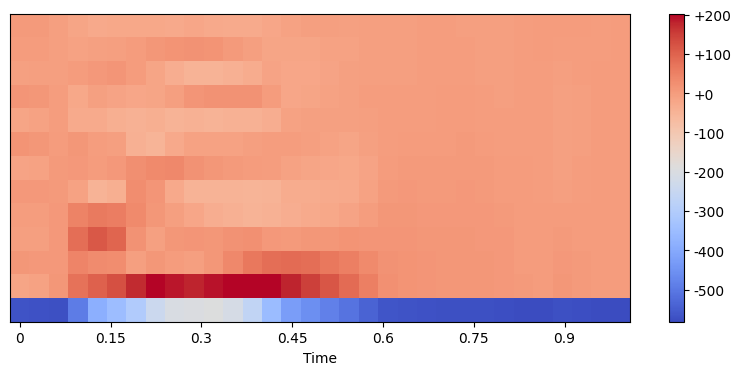

In [5]:
# Small demonstration on how the waveforms look like with their corresponding MFCCs
for i in range(10): 
    time = np.arange(0, len(wave[i])) / 16000
    
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, wave[i], linewidth=0.5)
    plt.title(str(labels[i]))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    print('Audio playback')
    display.display(display.Audio(wave[i], rate=16000))
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc[i], 
                         x_axis="time",sr=16000
                         )
    plt.colorbar(format="%+2.f")
    plt.show()

Here, we spot the largest timeframe length of the mfccs present, so that we can pad the other mfccs with 0 in order to maintain uniformity in the length of each mfcc

In [6]:
# To find the maximum time frame an mfcc
max_length=float('-inf')
for i in mfcc:
   print(len(i[0]))
   max_length=max(max_length,len(i[0]))
   print(max_length)


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
30
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
29
32
30
32
32
32
32
32
31
32
25
32
32
32
32
32
32
32
32
32
32
32
32
32
23
32
32
32
32
32
23
32
21
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
18
32
19
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
24
32
32
32
32
32
32
32
32
32
23
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
30
32
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
23
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
3

In [7]:
# Zero Padding the MFCCs so that the shape of each MFCCs remain constant  
labels=np.array(labels)
labels.shape
print(len(mfcc))
max_length=100 #for conveniencek
mfcc = [np.pad(mfc, ((0, 0), (0, max_length - len(mfc[0]))), mode='constant') if len(mfc[0])<max_length else mfc[:,:max_length] for mfc in mfcc]
print(len(mfcc))

22130


22130


Preparing the training and testing datasets

In [8]:
# We use Label Encoder to convert categorical data to numerical data
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [9]:
# Making Training and Testing datasets with a 80/20 split and shuffling enabled
X_train, X_test, y_train, y_test = train_test_split(
    mfcc, numeric_labels, test_size=0.2, random_state=42
)

In [10]:
# Making numpy array for reshaping
X_train=np.array(X_train)
X_test=np.array(X_test)

In [11]:
# Dimensions  will be ( Number of mfccs list, number of mfccs in each list, time frames for each mfcc list, extra dimension to act as a channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [12]:
X_train.shape

(17704, 13, 100, 1)

In [13]:
X_test.shape

(4426, 13, 100, 1)

In [14]:
# Dividing the testing dataset into validation and testing 
X_test,X_val=X_test[len(X_test)//2:],X_test[:len(X_test)//2]
y_test,y_val=y_test[len(y_test)//2:],y_test[:len(y_test)//2]
print(X_test.shape,X_val.shape)
print(y_test.shape,y_val.shape)

(2213, 13, 100, 1) (2213, 13, 100, 1)
(2213,) (2213,)


In [15]:
# Making the model which is essentially a CNN with LSTM
# In this  model, Global Average Pooling is used to make an average off all the features  extracted
model = Sequential()

#FEATURE EXTRACTION

# to extract spatial features
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1),kernel_regularizer=l2(0.0001))) #L2 regularization adds a penalty term to the loss function, which is proportional to the square of the magnitude of the weights 
model.add(BatchNormalization()) # To normalize the data by re-centering and re-scaling
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l2(0.0001)))

model.add(Conv2D(128, 3, activation='relu', padding='same',kernel_regularizer=l2(0.0001)))
model.add(GlobalAveragePooling2D())# Give an output of 128 features in a row, averaged over the 128 filtered outputs we get from the previous Conv2D layer
model.add(Dropout(0.2))


model.add(Reshape((-1, 128)))  

model.add(LSTM(64, return_sequences=True)) # Helps in retaining the temporal dependencies and memorizes it for further training sets 

#CLASSIFICATION
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(set(numeric_labels)), activation='softmax')) # gives the probabilites of each label


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model

y=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),batch_size=64,)

# The number of epochs used here is 100, hence it takes a long time to have it trained

Epoch 1/50
277/277 [==============================] - 371s 1s/step - loss: 1.6740 - accuracy: 0.2351 - val_loss: 1.5632 - val_accuracy: 0.2915
Epoch 2/50
277/277 [==============================] - 317s 1s/step - loss: 1.5654 - accuracy: 0.2941 - val_loss: 1.5424 - val_accuracy: 0.3150
Epoch 3/50
277/277 [==============================] - 309s 1s/step - loss: 1.5335 - accuracy: 0.3147 - val_loss: 1.4966 - val_accuracy: 0.3502
Epoch 4/50
277/277 [==============================] - 183s 662ms/step - loss: 1.4929 - accuracy: 0.3464 - val_loss: 1.4303 - val_accuracy: 0.3778
Epoch 5/50
277/277 [==============================] - 198s 716ms/step - loss: 1.4176 - accuracy: 0.3978 - val_loss: 1.3478 - val_accuracy: 0.4654
Epoch 6/50
277/277 [==============================] - 202s 730ms/step - loss: 1.3464 - accuracy: 0.4423 - val_loss: 1.2611 - val_accuracy: 0.5043
Epoch 7/50
277/277 [==============================] - 202s 728ms/step - loss: 1.2784 - accuracy: 0.4759 - val_loss: 1.1823 - val_accu

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')



70/70 [==============================] - 6s 89ms/step - loss: 0.2607 - accuracy: 0.9132
Test accuracy: 91.32%


Text(0, 0.5, 'Accuracy [%]')

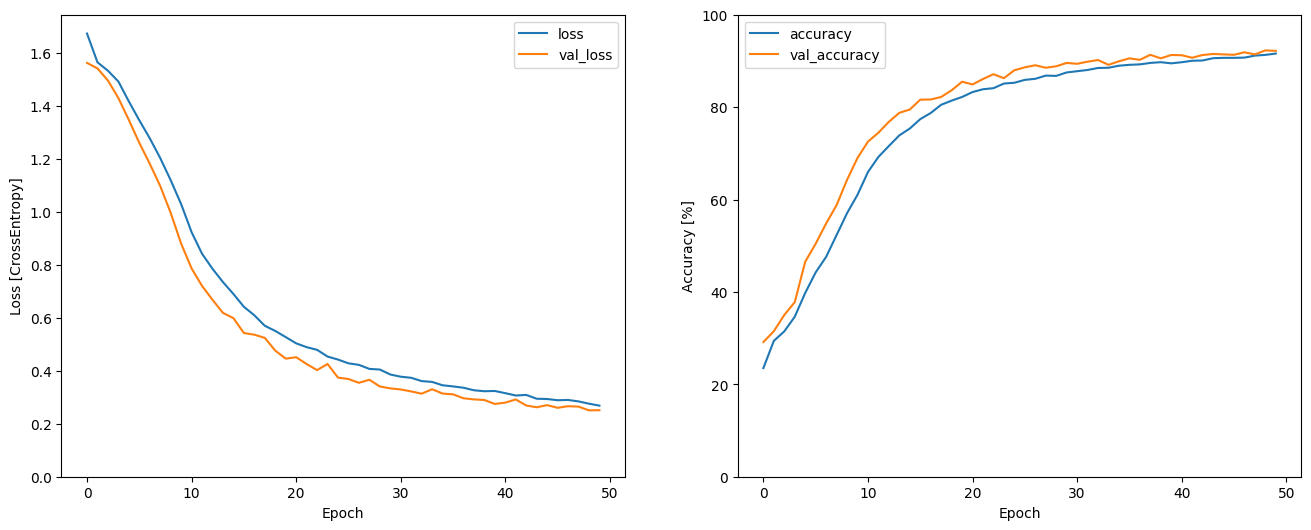

In [17]:
#Model metrics
metrics = y.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(y.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(y.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

70/70 [==============================] - 6s 78ms/step


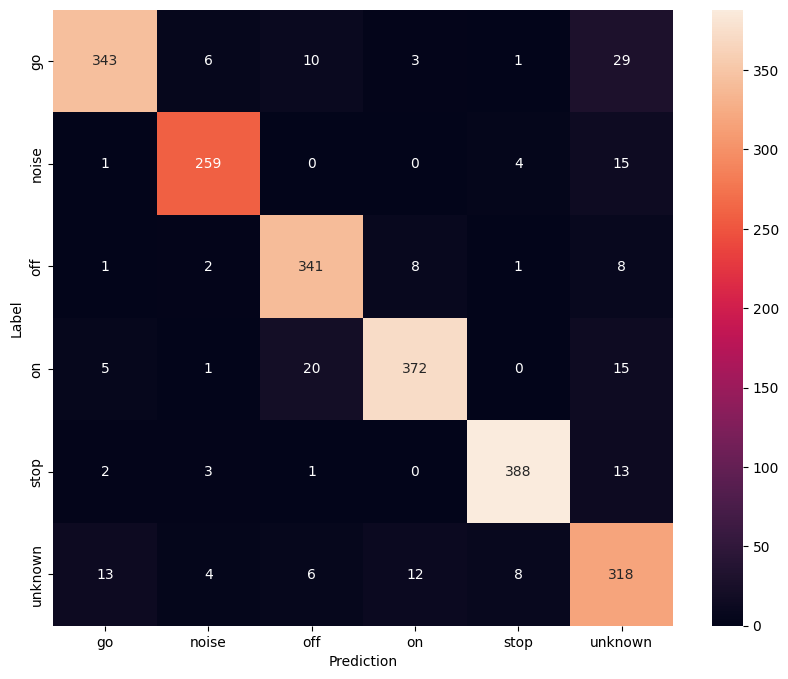

In [18]:
# Confusion Matrix
y_pred=model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(y_test, axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Saving the model using Keras saved model

In [19]:
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [20]:
loaded_model = models.load_model("saved_model")

MAKING A REAL-TIME INFERENCING FOR THE ABOVE MODELS

In [21]:
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16 # -32768 to 32767
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

# Record a time interval for 1 second
def record():
 stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=FRAMES_PER_BUFFER
 )

 frames = []
 seconds = 1
 for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)#input from the user
        frames.append(data)
 stream.stop_stream()
 stream.close()
 return np.frombuffer(b''.join(frames), dtype=np.int16)

In [22]:
# making MFCC from the waveform obtained
def get_mfcc(audio):
    mfccs=librosa.feature.mfcc(y=audio,sr=16000,n_mfcc=13)
    if len(mfccs[0]) < max_length:
       mfccs = np.pad(mfccs, ((0, 0), (0, max_length - len(mfccs[0]))), mode='constant')
    else:
       mfccs = mfccs[:, :max_length]
    mfccs=mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1)
    mfccs=np.array(mfccs)
    mfccs=mfccs[np.newaxis,:]
    return mfccs

In [23]:
# Making the MFCC's shape suitable to be an input for the models
def preprocessing(audio):
    audio=[i/32768 for i in audio]
    audio=np.array(audio)
    mfccs=librosa.feature.mfcc(y=audio,sr=16000,n_mfcc=13)
    
    if len(mfccs[0]) < max_length:
       mfccs = np.pad(mfccs, ((0, 0), (0, max_length - len(mfccs[0]))), mode='constant')
    else:
       mfccs = mfccs[:, :max_length]
    
    mfccs=mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1)
    mfccs=np.array(mfccs)
    mfccs=mfccs[np.newaxis,:]
    return mfccs

In [26]:
# max_length=100

# commands = ['go' ,'noise', 'off', 'on' ,'stop' ,'unknown']
# def predict_mic():
#     audio = record()
#     spec = preprocessing(audio)
#     prediction = loaded_model(spec)
#     label_pred = np.argmax(prediction, axis=1)
#     command = commands[label_pred[0]]
#     print("Predicted label:", command)
#     return command

# if __name__ == "__main__":
#     while True:
#         command=predict_mic()

Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go
Predicted label: go


KeyboardInterrupt: 